In [14]:
import pandas as pd
import rpy2 as rpy2
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from Helpers.FunctHelpers import *
from Helpers.PlotHelpers import *

In [15]:
# Download data

tickers = pd.read_excel('Data/SandP500list.xlsx')
tickers = tickers[tickers['sector'] == 'Financials']
names = tickers['symbol'].tolist()

start_date = pd.to_datetime('2022-01-01') # train 12 months
end_date = pd.to_datetime('2023-07-01') # test 6 months

data = download_data(names, start_date, end_date)

[*********************100%***********************]  65 of 65 completed


6 Failed downloads:
['WLTW', 'RE', 'PBCT', 'FRC', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SIVB']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [16]:
# Split into train and test data

train_start = pd.to_datetime('2022-01-01')
train_end = pd.to_datetime('2022-12-31')
test_start = pd.to_datetime('2023-01-01')
test_end = pd.to_datetime('2023-07-01')

train_data, test_data = train_test_split(data, train_start, train_end, test_start, test_end)
print(train_data.shape, test_data.shape)

(251, 59) (124, 59)


In [17]:
# Calculate SSD and select 20 pairs with lowest SSD

train_data_cum = train_data.pct_change().cumsum().dropna(axis=0)

ssd_train = find_ssd(train_data_cum)
pairs = select_lowest_ssd(ssd_train, train_data_cum)

print(f'Choosen pairs: {len(pairs)} from {round(len(data.columns) * (len(data.columns) - 1) / 2)} posssible pairs')

Choosen pairs: 20 from 1711 posssible pairs


In [18]:
#plot_min_ssd_pairs(pairs, train_data_cum)

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import norm, logistic, genextreme
from scipy.optimize import minimize


# Calculate daily returns from cumulative returns
returns = train_data.pct_change().dropna(axis=0)

# Define a function to fit a distribution and calculate AIC
def fit_distribution(data, dist_name):
    # Fit the distribution
    if dist_name == "norm":
        dist = norm
    elif dist_name == "logistic":
        dist = logistic
    elif dist_name == "genextreme":
        dist = genextreme
        
    params = dist.fit(data)
    
    # Calculate negative log likelihood
    nll = -np.sum(dist.logpdf(data, *params))
    
    # Calculate AIC
    k = len(params)
    aic = 2*k + 2*nll
    
    return params, aic

# Fit distributions for the 'AFL' and 'AIG' stocks
afl_params_norm, afl_aic_norm = fit_distribution(returns['AFL'], 'norm')
afl_params_logistic, afl_aic_logistic = fit_distribution(returns['AFL'], 'logistic')
afl_params_genextreme, afl_aic_genextreme = fit_distribution(returns['AFL'], 'genextreme')

aig_params_norm, aig_aic_norm = fit_distribution(returns['AIG'], 'norm')
aig_params_logistic, aig_aic_logistic = fit_distribution(returns['AIG'], 'logistic')
aig_params_genextreme, aig_aic_genextreme = fit_distribution(returns['AIG'], 'genextreme')

{
    "AFL": {
        "norm": {"params": afl_params_norm, "aic": afl_aic_norm},
        "logistic": {"params": afl_params_logistic, "aic": afl_aic_logistic},
        "genextreme": {"params": afl_params_genextreme, "aic": afl_aic_genextreme}
    },
    "AIG": {
        "norm": {"params": aig_params_norm, "aic": aig_aic_norm},
        "logistic": {"params": aig_params_logistic, "aic": aig_aic_logistic},
        "genextreme": {"params": aig_params_genextreme, "aic": aig_aic_genextreme}
    }
}

print(f'AFL: norm AIC = {afl_aic_norm}, logistic AIC = {afl_aic_logistic}, genextreme AIC = {afl_aic_genextreme}')

AFL: norm AIC = -1391.6794376972755, logistic AIC = -1392.2169874462488, genextreme AIC = -1370.985455028554


In [20]:
# Transform returns to uniform using the CDF of the fitted GEV distributions
uniform_afl = genextreme.cdf(returns['AFL'], *afl_params_genextreme)
uniform_aig = genextreme.cdf(returns['AIG'], *aig_params_genextreme)

# Combine into a DataFrame
uniform_data = pd.DataFrame({'AFL': uniform_afl, 'AIG': uniform_aig})

print(uniform_data.head())

        AFL       AIG
0  0.976153  0.889874
1  0.539377  0.257497
2  0.893469  0.777261
3  0.865623  0.874236
4  0.816136  0.690202


In [21]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Enable automatic conversion between pandas dataframes and R data.frames
pandas2ri.activate()

# Import R's "copula" package
copula = importr('copula')
VineCopula = importr('VineCopula')

# Define the R script to fit copulas
r_script = """
library(copula)

# Assuming you have a dataframe 'df' in your environment already
gumbelCop = gumbelCopula(dim = 2)
claytonCop = claytonCopula(dim = 2)
normalCop = normalCopula(dim = 2)

# Fit the copulas to data
fit_gumbel = fitCopula(gumbelCop, data=df, method="ml")
fit_clayton = fitCopula(claytonCop, data=df, method="ml")
fit_normal = fitCopula(normalCop, data=df, method="ml")

# You can return or analyze the fitted models as needed
list(fit_gumbel, fit_clayton, fit_normal)
"""

# Convert your pandas DataFrame to an R dataframe
r_dataframe = pandas2ri.py2rpy(uniform_data)

# Assign the DataFrame to an R variable
ro.globalenv['df'] = r_dataframe

# Run the R script
result = ro.r(r_script)

# Convert the result back to Python format if needed, or handle in R
print(result)


R[write to console]: Zusätzlich: 
R[write to console]: Warnmeldungen:

R[write to console]: 1: 
R[write to console]: In .local(copula, data, ...) :
R[write to console]:  coercing 'data' to a matrix.

R[write to console]: 2: 
R[write to console]: In .local(copula, data, ...) :
R[write to console]:  coercing 'data' to a matrix.

R[write to console]: 3: 
R[write to console]: In .local(copula, data, ...) :
R[write to console]:  coercing 'data' to a matrix.



[[1]]
Call: fitCopula(gumbelCop, data = df, ... = pairlist(method = "ml"))
Fit based on "maximum likelihood" and 250 2-dimensional observations.
Copula: gumbelCopula 
alpha 
2.271 
The maximized loglikelihood is 110.3 
Optimization converged

[[2]]
Call: fitCopula(claytonCop, data = df, ... = pairlist(method = "ml"))
Fit based on "maximum likelihood" and 250 2-dimensional observations.
Copula: claytonCopula 
alpha 
  2.9 
The maximized loglikelihood is 35.96 
Optimization converged

[[3]]
Call: fitCopula(normalCop, data = df, ... = pairlist(method = "ml"))
Fit based on "maximum likelihood" and 250 2-dimensional observations.
Copula: normalCopula 
rho.1 
0.768 
The maximized loglikelihood is 105.9 
Optimization converged




In [23]:
import numpy as np
import pandas as pd
from scipy.stats import genextreme
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Enable automatic conversion between pandas dataframes and R data.frames
pandas2ri.activate()

# Import R's "copula" package
copula = importr('copula')

# Ensure data is strictly within [0, 1]
uniform_data = uniform_data.clip(0, 1)

# Convert your pandas DataFrame to an R dataframe and pass to R environment
r_uniform_data = pandas2ri.py2rpy(uniform_data)
ro.globalenv['df'] = r_uniform_data

# R script to define and fit the copula, then use it for calculating conditional probabilities
r_script = """
library(copula)
# Fit a Gumbel copula to the data
gumbelCop <- gumbelCopula(dim = 2)
fit_gumbel <- fitCopula(gumbelCop, df, method = "ml")

# Function to calculate conditional probability h1 for u2 given u1 = 0.5
h1 <- function(u2) {
  sapply(u2, function(x) pCopula(c(0.5, x), copula = fit_gumbel@copula))
}

# Function to calculate conditional probability h2 for u1 given u2 = 0.5
h2 <- function(u1) {
  sapply(u1, function(x) pCopula(c(x, 0.5), copula = fit_gumbel@copula))
}

# Calculate conditional probabilities
h1_values <- h1(df$AIG)
h2_values <- h2(df$AFL)

list(h1_values = h1_values, h2_values = h2_values)
"""

# Run the R script and get results
results = ro.r(r_script)

# Extract results from R to Python
h1_values = np.array(results.rx2('h1_values'))
h2_values = np.array(results.rx2('h2_values'))

# Calculate mispricing indices
# Mispricing index calculations with a different threshold for demonstration
m1 = h1_values - 0.45  # Adjusting threshold to 0.45 from 0.5
m2 = h2_values - 0.45


# Generate trading signals based on mispricing indices
signals = ['Buy AFL, Sell AIG' if m1_i > 0 and m2_i < 0 else 'Sell AFL, Buy AIG' if m1_i < 0 and m2_i > 0 else 'No action' for m1_i, m2_i in zip(m1, m2)]

# Assuming some threshold to close positions
threshold = 0.1
close_signals = ['Close' if abs(m1_i) < threshold and abs(m2_i) < threshold else 'Keep' for m1_i, m2_i in zip(m1, m2)]

# Print outputs
print("Trading Signals:", signals)
print("Close Signals:", close_signals)


R[write to console]: Zusätzlich: 
R[write to console]: Warnmeldung:

R[write to console]: In .local(copula, data, ...) :
R[write to console]:  coercing 'data' to a matrix.



Trading Signals: ['No action', 'No action', 'No action', 'No action', 'No action', 'Sell AFL, Buy AIG', 'No action', 'Buy AFL, Sell AIG', 'Sell AFL, Buy AIG', 'No action', 'No action', 'No action', 'No action', 'Sell AFL, Buy AIG', 'No action', 'Sell AFL, Buy AIG', 'No action', 'No action', 'No action', 'Buy AFL, Sell AIG', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'Buy AFL, Sell AIG', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'Sell AFL, Buy AIG', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'No action', 'Sell AFL, Buy AIG', 'No action', 'No action', 'No action', 'Sell AFL, Buy AIG', 'Sell AFL, Buy AIG', 'No action', 'No action', 'No action', 'No action

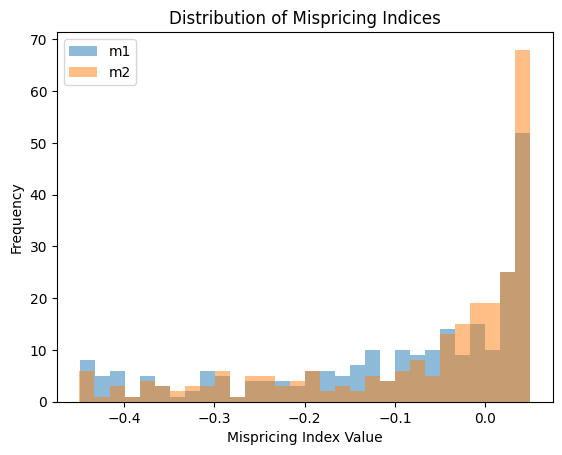

In [24]:
import matplotlib.pyplot as plt

plt.hist(m1, bins=30, alpha=0.5, label='m1')
plt.hist(m2, bins=30, alpha=0.5, label='m2')
plt.legend()
plt.title('Distribution of Mispricing Indices')
plt.xlabel('Mispricing Index Value')
plt.ylabel('Frequency')
plt.show()
